# Atividade de Redes Convolucionais

## Felipe Gibin

## 1. Introdução

### 1.1 Bibliotecas

In [1]:
#Bibliotecas usadas
from tensorflow.keras.preprocessing import image_dataset_from_directory
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping

## 2. Pré-processamento e Organização dos Dados

### 2.1 Estrutura do Dataset

O dataset segue a seguinte estrutura:

```text
clouds/
├── cloud_train/
│   ├── cirriform clouds/
│   ├── cumulonimbus clouds/
│   ├── stratiform clouds/
│   ├── clear sky/
│   └── ... (outros tipos de nuvem)
└── cloud_test/
    ├── cirriform clouds/
    ├── cumulonimbus clouds/
    ├── stratiform clouds/
    ├── clear sky/
    └── ... (outros tipos de nuvem)
```


### 2.2 Carregar os Dados

In [2]:
drive.mount('/content/drive') # Google drive

#Caminhos para os diretórios de treino e teste
train_dir = '/content/drive/MyDrive/clouds/clouds_train'
test_dir = '/content/drive/MyDrive/clouds/clouds_test'

Mounted at /content/drive


In [3]:
#Checa a distribuição dos diretórios de treino e teste
def contar_imagens_por_classe(diretorio_base):
    total = 0
    print(f'\nDiretório: {diretorio_base}')
    for classe in os.listdir(diretorio_base):
        caminho_classe = os.path.join(diretorio_base, classe)
        if os.path.isdir(caminho_classe):
            num_imgs = len([f for f in os.listdir(caminho_classe) if os.path.isfile(os.path.join(caminho_classe, f))])
            total += num_imgs
            print(f'  Classe "{classe}": {num_imgs} imagens')
    print(f'Total de imagens em {diretorio_base}: {total}')
    return total


# Contagem
contar_imagens_por_classe(train_dir)
contar_imagens_por_classe(test_dir)



Diretório: /content/drive/MyDrive/clouds/clouds_train
  Classe "cirriform clouds": 66 imagens
  Classe "stratiform clouds": 49 imagens
  Classe "cumulonimbus clouds": 14 imagens
  Classe "stratocumulus clouds": 61 imagens
  Classe "high cumuliform clouds": 133 imagens
  Classe "clear sky": 60 imagens
  Classe "cumulus clouds": 91 imagens
Total de imagens em /content/drive/MyDrive/clouds/clouds_train: 474

Diretório: /content/drive/MyDrive/clouds/clouds_test
  Classe "cumulus clouds": 120 imagens
  Classe "stratocumulus clouds": 71 imagens
  Classe "high cumuliform clouds": 103 imagens
  Classe "stratiform clouds": 40 imagens
  Classe "clear sky": 64 imagens
  Classe "cirriform clouds": 77 imagens
  Classe "cumulonimbus clouds": 11 imagens
Total de imagens em /content/drive/MyDrive/clouds/clouds_test: 486


486

### 2.3 Dividir os dados

É preciso reorganizar o dataset de forma a aumentar a quantidade de dados em train_data. Uma divisão 50-50% é muito incomum e não faz sentido. Vamos resolver isso de forma a aumentar a proporção de train_data para 80%. Criei uma pasta nova no drive chamada clouds_all. contendo todas as imagens para cada tipo de núvem, de forma que a nova estrutura dos diretórios é:

```text
clouds_all/
├── cirriform clouds/
├── cumulonimbus clouds/
├── stratiform clouds/
├── clear sky/
├── cumulus clouds/
├── high cumuliform clouds/
├── stratocumulus clouds/
```

In [4]:
# Configurações
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 123
all_data_dir = '/content/drive/MyDrive/clouds/clouds_all'

# Criar dataset completo
full_ds = image_dataset_from_directory(
    all_data_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True,
    seed=SEED
)

# Calcular tamanho do dataset
total_images = len(full_ds.file_paths)
train_size = int(0.75 * total_images)   #75% treino
val_size = int(0.1 * total_images)      #10% validacao
test_size = total_images - train_size - val_size  #15% teste

print(f"Total de imagens: {total_images}")
print(f"Treino: {train_size} | Validação: {val_size} | Teste: {test_size}")

# Criar datasets divididos
train_ds = full_ds.take(train_size // BATCH_SIZE)
remaining = full_ds.skip(train_size // BATCH_SIZE)
val_ds = remaining.take(val_size // BATCH_SIZE)
test_ds = remaining.skip(val_size // BATCH_SIZE)

Found 960 files belonging to 7 classes.
Total de imagens: 960
Treino: 720 | Validação: 96 | Teste: 144


### 2.3 Visualização de algumas imagens

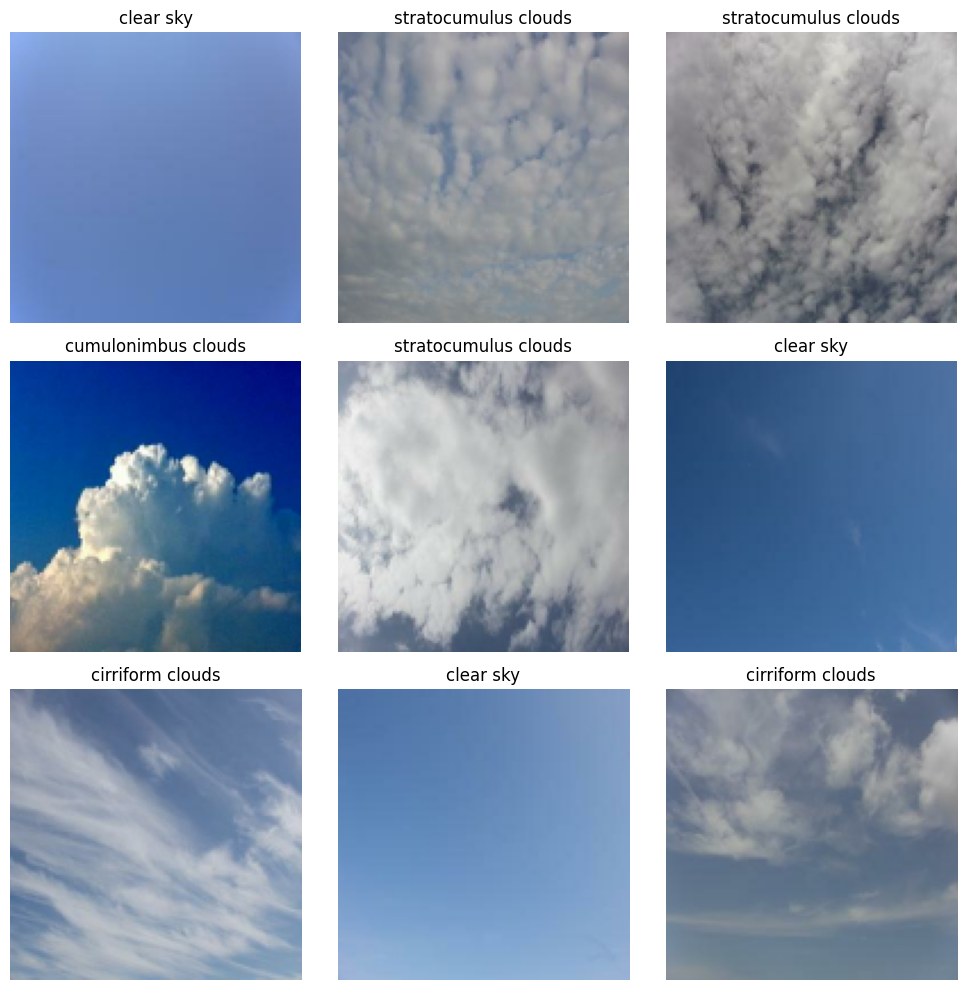

In [10]:
#Pega o nome das classes de full_ds
class_names = full_ds.class_names

# pega apenas o primeiro batch
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):  # mostrar 9 imagens aleatórias
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy().argmax()])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

## 3. CNN sem data augmentation



### 3.1 Definindo o modelo

In [11]:
model_cnn_no_reg = Sequential([
    layers.Input(shape=(128,128, 3)),
    layers.Rescaling(1./255),  # Normalização

    # Blocos Convolucionais
    layers.Conv2D(32, (3, 3), activation="relu", padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu", padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu", padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),  # Processa o resultado do flatten
    layers.Dense(7, activation="softmax")  # 7 classes
])

### 3.2 Treinamento

In [14]:
model_cnn_no_reg.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_cnn_no_reg = model_cnn_no_reg.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.1832 - loss: 2.1288 - val_accuracy: 0.2292 - val_loss: 1.7244
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 641ms/step - accuracy: 0.3236 - loss: 1.6385 - val_accuracy: 0.4271 - val_loss: 1.3840
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 274ms/step - accuracy: 0.4272 - loss: 1.3423 - val_accuracy: 0.4688 - val_loss: 1.2736
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.5046 - loss: 1.1688 - val_accuracy: 0.5208 - val_loss: 1.1668
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.5373 - loss: 1.1078 - val_accuracy: 0.4896 - val_loss: 1.1704
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.5694 - loss: 1.1052 - val_accuracy: 0.5312 - val_loss: 1.1866
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.5776 - loss: 1.0390 - val_accuracy: 0.6875 - val_loss: 0.9902
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.6088 - loss: 0.9142 - val_accuracy: 0.

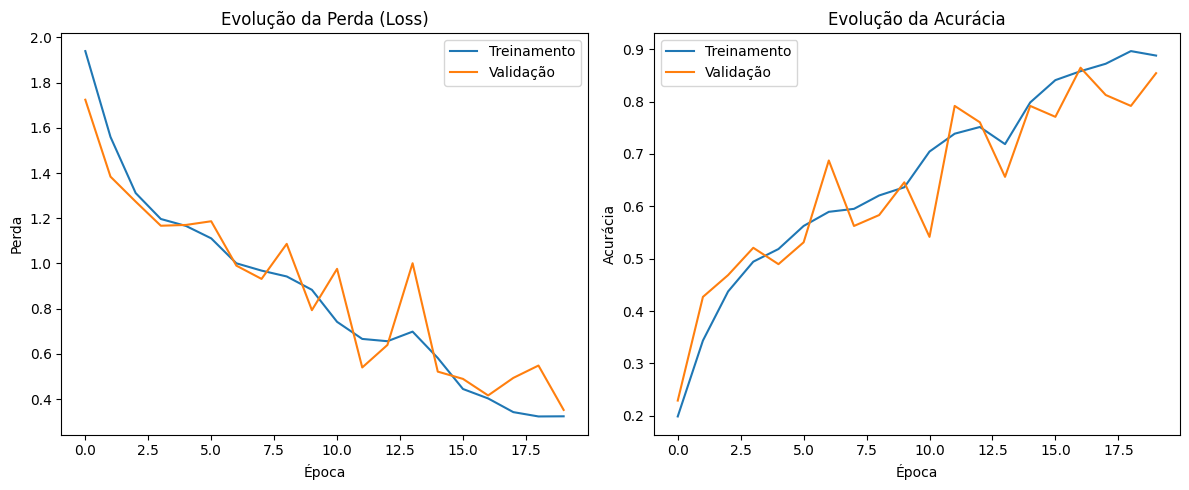

In [15]:
#Evolução das curvas de perda e acurácia

plt.figure(figsize=(12, 5))

# Curva de perda
plt.subplot(1, 2, 1)
plt.plot(history_cnn_no_reg.history['loss'], label='Treinamento')
plt.plot(history_cnn_no_reg.history['val_loss'], label='Validação')
plt.title('Evolução da Perda (Loss)')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

# Curva de acurácia
plt.subplot(1, 2, 2)
plt.plot(history_cnn_no_reg.history['accuracy'], label='Treinamento')
plt.plot(history_cnn_no_reg.history['val_accuracy'], label='Validação')
plt.title('Evolução da Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()


Avaliar de novo.








Vemos que há indícios de overfitting, o que não surpreende dada a ausência de data augmentation nesse modelo. Podemos destacar que a acurácia de treinamento aumenta consistentemente, mas a de avaliação não acompanha o mesmo ritmo e oscila. De forma similar, a perda de validação começa a oscilar e até aumenta, mesmo com a perda de treino caindo.


### 3.3 Avaliação breve

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Classes presentes: [0 1 2 3 4 5 6]


<Figure size 1200x1000 with 0 Axes>

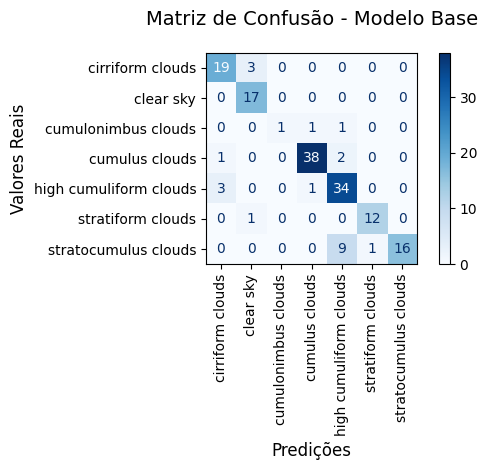

In [17]:
y_true = []
y_pred_probs = []

for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_probs.extend(model_cnn_no_reg.predict(images))

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.array(y_true)

# 1. Garantir que todas as classes estão representadas
unique_classes = np.unique(np.concatenate([y_true, y_pred]))
print("Classes presentes:", unique_classes)

# 2. Criar matriz de confusão com todas as classes
cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))

# 3. Plotar com configurações robustas
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names  # Usar todos os nomes de classe originais
)

# 4. Configuração à prova de erros
plot = disp.plot(
    cmap='Blues',
    xticks_rotation=90,
    values_format='d',
    include_values=True
)

# Ajustes finais
plt.title("Matriz de Confusão - Modelo Base", pad=20, fontsize=14)
plt.xlabel('Predições', fontsize=12)
plt.ylabel('Valores Reais', fontsize=12)
plt.tight_layout()

# Verificar se há classes ausentes
if len(unique_classes) < len(class_names):
    missing = set(range(len(class_names))) - set(unique_classes)
    print(f"\nAviso: Classes ausentes nos dados de teste: {[class_names[i] for i in missing]}")

plt.show()

In [18]:
# Report básico
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

                        precision    recall  f1-score   support

      cirriform clouds       0.83      0.86      0.84        22
             clear sky       0.81      1.00      0.89        17
   cumulonimbus clouds       1.00      0.33      0.50         3
        cumulus clouds       0.95      0.93      0.94        41
high cumuliform clouds       0.74      0.89      0.81        38
     stratiform clouds       0.92      0.92      0.92        13
  stratocumulus clouds       1.00      0.62      0.76        26

              accuracy                           0.86       160
             macro avg       0.89      0.79      0.81       160
          weighted avg       0.87      0.86      0.85       160



## 4. CNN com regularização

### 4.1 Definindo o modelo

In [34]:
model_cnn = Sequential([
    layers.Input(shape=(128,128,3)),

    # Data augmentation (pode colocar fora do modelo, mas deixei aqui pra manter seu estilo)
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),  # aumentei um pouco a rotação
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),

    layers.Rescaling(1./255),

    # Blocos convolucionais mais profundos
    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.4),

    # Flatten + Fully connected
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(7, activation="softmax")
])

### 4.2 Treinamento

In [35]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model_cnn.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_cnn = model_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)]
)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 260ms/step - accuracy: 0.3279 - loss: 2.2109 - val_accuracy: 0.2604 - val_loss: 5.9748
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 274ms/step - accuracy: 0.4773 - loss: 1.5406 - val_accuracy: 0.2188 - val_loss: 2.5890
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 250ms/step - accuracy: 0.5673 - loss: 1.2843 - val_accuracy: 0.2292 - val_loss: 3.3174
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - accuracy: 0.6162 - loss: 1.0906 - val_accuracy: 0.2500 - val_loss: 3.1773
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 251ms/step - accuracy: 0.6782 - loss: 0.9746 - val_accuracy: 0.2188 - val_loss: 3.0879


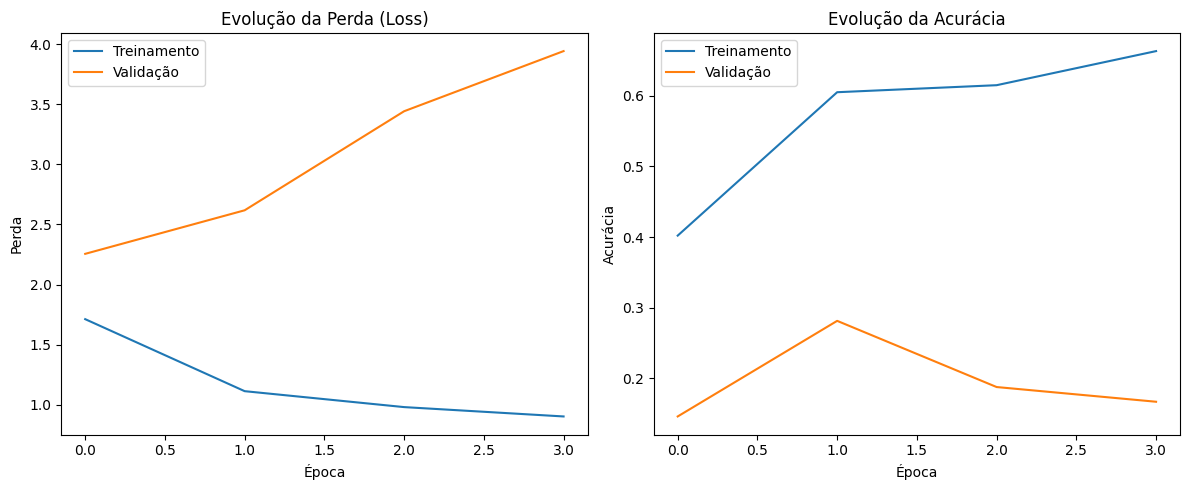

In [23]:
#Evolução das curvas de perda e acurácia

plt.figure(figsize=(12, 5))

# Curva de perda
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Treinamento')
plt.plot(history_cnn.history['val_loss'], label='Validação')
plt.title('Evolução da Perda (Loss)')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

# Curva de acurácia
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Treinamento')
plt.plot(history_cnn.history['val_accuracy'], label='Validação')
plt.title('Evolução da Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()

### 4.3 Avaliação

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Classes presentes: [0 1 2 3 4 5 6]


<Figure size 1200x1000 with 0 Axes>

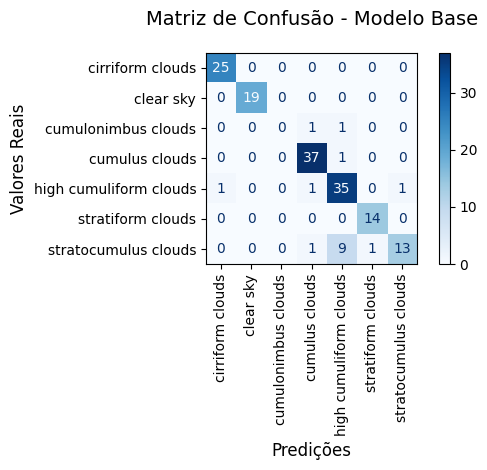

In [25]:
y_true = []
y_pred_probs = []

for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_probs.extend(model_cnn_no_reg.predict(images))

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.array(y_true)

# 1. Garantir que todas as classes estão representadas
unique_classes = np.unique(np.concatenate([y_true, y_pred]))
print("Classes presentes:", unique_classes)

# 2. Criar matriz de confusão com todas as classes
cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))

# 3. Plotar com configurações robustas
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names  # Usar todos os nomes de classe originais
)

# 4. Configuração à prova de erros
plot = disp.plot(
    cmap='Blues',
    xticks_rotation=90,
    values_format='d',
    include_values=True
)

# Ajustes finais
plt.title("Matriz de Confusão - Modelo Base", pad=20, fontsize=14)
plt.xlabel('Predições', fontsize=12)
plt.ylabel('Valores Reais', fontsize=12)
plt.tight_layout()

# Verificar se há classes ausentes
if len(unique_classes) < len(class_names):
    missing = set(range(len(class_names))) - set(unique_classes)
    print(f"\nAviso: Classes ausentes nos dados de teste: {[class_names[i] for i in missing]}")

plt.show()

In [38]:
# Report básico
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# Avaliação no conjunto de teste
test_loss, test_acc = model_cnn.evaluate(test_ds)
print(f'\nTest Accuracy: {test_acc:.4f}')

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                        precision    recall  f1-score   support

      cirriform clouds       0.96      1.00      0.98        25
             clear sky       1.00      1.00      1.00        19
   cumulonimbus clouds       0.00      0.00      0.00         2
        cumulus clouds       0.93      0.97      0.95        38
high cumuliform clouds       0.76      0.92      0.83        38
     stratiform clouds       0.93      1.00      0.97        14
  stratocumulus clouds       0.93      0.54      0.68        24

              accuracy                           0.89       160
             macro avg       0.79      0.78      0.77       160
          weighted avg       0.89      0.89      0.88       160

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.3549 - loss: 2.6405

Test Accuracy: 0.3187


In [37]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

# Construção do modelo
model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(128, 128, 3)),  # Normalização

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(7, activation='softmax')  # 7 classes
])

# Compilação
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Treinamento
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1
)

# Avaliação no conjunto de teste
test_loss, test_acc = model.evaluate(test_ds)
print(f'\nTest Accuracy: {test_acc:.4f}')


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_7 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_7 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 0.2073 - loss: 2.1122 - val_accuracy: 0.3333 - val_loss: 1.5525
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - accuracy: 0.3515 - loss: 1.5567 - val_accuracy: 0.3438 - val_loss: 1.5043
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - accuracy: 0.3824 - loss: 1.4540 - val_accuracy: 0.4896 - val_loss: 1.3738
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.4298 - loss: 1.3809 - val_accuracy: 0.4167 - val_loss: 1.3241
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 229ms/step - accuracy: 0.4760 - loss: 1.2829 - val_accuracy: 0.6146 - val_loss: 1.1164
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - accuracy: 0.4872 - loss: 1.2855 - val_accuracy: 0.4375 - val_loss: 1.3080
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - accuracy: 0.4734 - loss: 1.2313 - val_accuracy: 0.5312 - val_loss: 1.1144
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - accuracy: 0.5204 - loss: 1.1856 - val_accuracy: 0.